In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from numpy import array
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm

2022-10-10 00:35:01.107145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 00:35:01.107168: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Replace missing values with Zero and Gorup by month

In [3]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Demand', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [4]:
df= pd.read_csv('consumos.csv', parse_dates=['date'])
df.rename(columns = {'nr':'value'}, inplace = True)
df=df.groupby('date').sum()
df=df.resample(rule='MS').sum()

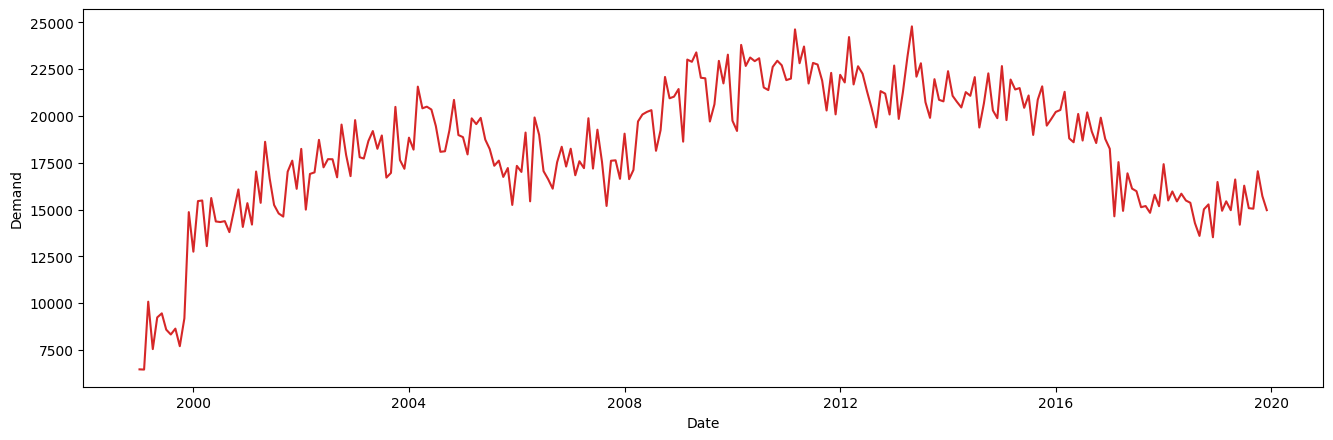

In [5]:
plot_df(df, x=df.index, y=df.value, title='')

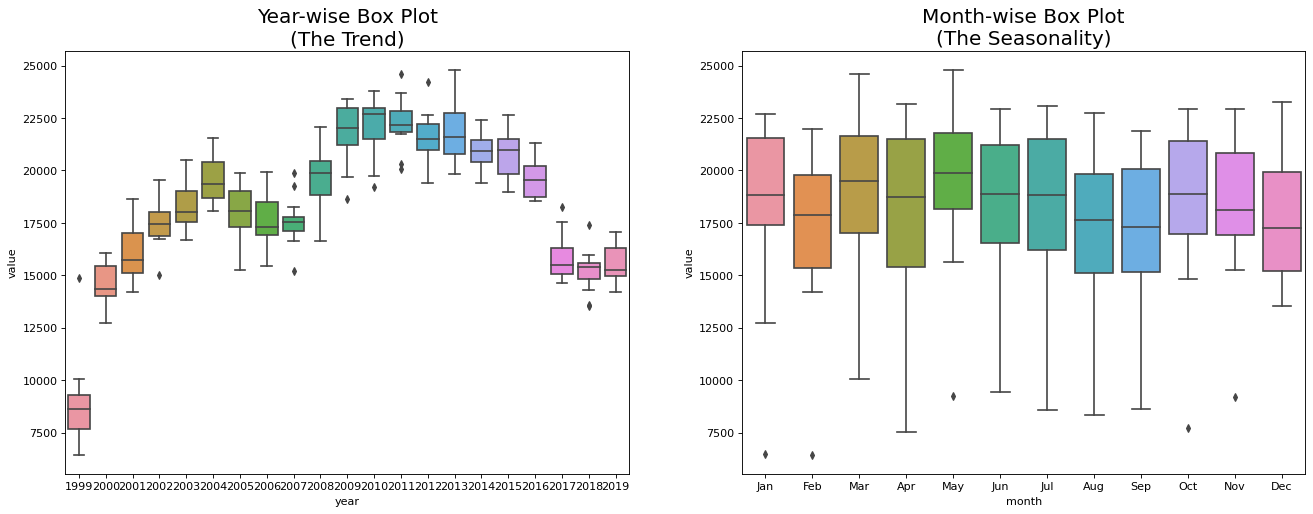

In [6]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

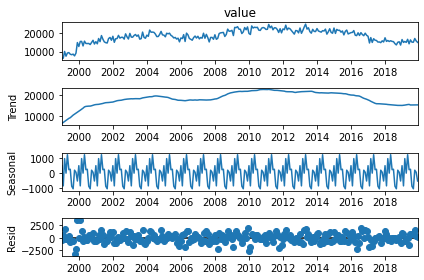

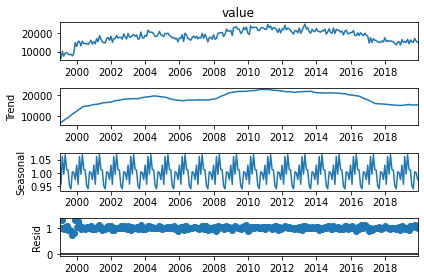

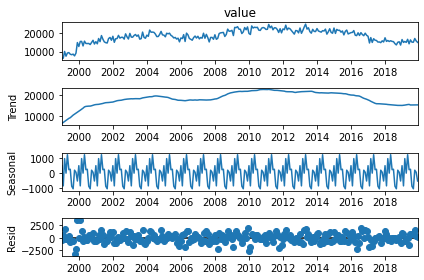

In [7]:
# Multiplicative Decomposition 
seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq').plot()
# Additive Decomposition
seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq').plot()

In [8]:
# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Value s:')
    print(f'   {key}, {value}')

ADF Statistic: -1.58760123153819
p-value: 0.4898187869297843
Critial Value s:
   1%, -3.4583663275730476
Critial Value s:
   5%, -2.8738660999177132
Critial Value s:
   10%, -2.5733390785693766


In [39]:
#SARIMA optimal parameters
smodel = pm.auto_arima(df[:240].value, start_p=1, start_q=1,
                         test='adf',
                         max_p=25, max_q=25, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=3905.891, Time=6.77 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4172.551, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4012.889, Time=1.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4087.987, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4175.476, Time=0.08 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=3975.764, Time=0.74 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=8.10 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=3900.031, Time=8.11 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=3916.637, Time=17.86 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=4080.670, Time=6.31 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=11.39 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=3901.891, Time=12.27 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=inf, Time=17.11 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=4134.536, Time=1.03 sec
 ARIMA(0,0,2)(0,1,2)[12] inter

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  240
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1944.015
Date:                                 Mon, 10 Oct 2022   AIC                           3900.031
Time:                                         01:03:57   BIC                           3920.607
Sample:                                              0   HQIC                          3908.332
                                                 - 240                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -8.0128      5.765     -1.390      0.165     -19.312       3.286
ar.L1          1.0000      0.003    312.770      0.000       0.994       1.006
ma.L1         -0.6765      0.045    -15.115      0.000      -0.764      -0.589
ma.S.L12      -0.6946      0.065    -10.666      0.000      -0.822      -0.567
ma.S.L24      -0.1687      0.059     -2.861      0.004      -0.284      -0.053
sigma2      1.413e+06   2.51e-05   5.64e+10      0.000    1.41e+06    1.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):                 2.54
Prob(Q):                              0.20   Prob(JB):                         0.28
Heteroskedasticity (H):               0.75   Skew:                            -0.22
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.72e+26. Standard errors may be unstable.
"""

In [41]:
smodel

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True)

In [42]:
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df[240:].index[0], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

In [43]:
actual = df[240:].value

In [44]:
rmse = sqrt(mean_squared_error(fitted, actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1716.921


In [45]:
mae = mean_absolute_error(fitted, actual)
print('Test MAE: %.3f' % mae)

Test MAE: 1495.594


In [46]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [47]:
MAPE(fitted, actual)

10.849427749195453

In [48]:
fitted_series

2019-01-01    15437.342492
2019-02-01    13842.199739
2019-03-01    15228.743558
2019-04-01    14330.421486
2019-05-01    15097.564232
2019-06-01    14410.567920
2019-07-01    14293.355749
2019-08-01    13161.334377
2019-09-01    12844.309165
2019-10-01    13906.661723
2019-11-01    13817.819628
2019-12-01    12863.691561
Freq: MS, dtype: float64

In [49]:
demand_prediction_sarima = fitted_series
%store demand_prediction_sarima

Stored 'demand_prediction_sarima' (Series)
